In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from collections import Counter
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, precision_recall_fscore_support

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

df = pd.read_csv("gdrive/My Drive/CRT Prediction/Ad_click_prediction_train.csv")

Mounted at /content/gdrive


# Разведочный анализ

In [4]:
df.shape

(463291, 15)

In [5]:
df.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,140690,2017-07-02 00:00,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0
1,333291,2017-07-02 00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0
2,129781,2017-07-02 00:00,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0
3,464848,2017-07-02 00:00,1097446,I,359520,13787,3,NaN,3.0,Male,3.0,3.0,2.0,1,0
4,90569,2017-07-02 00:01,663656,C,405490,60305,3,NaN,2.0,Male,2.0,3.0,2.0,1,0


<Axes: xlabel='is_click', ylabel='count'>

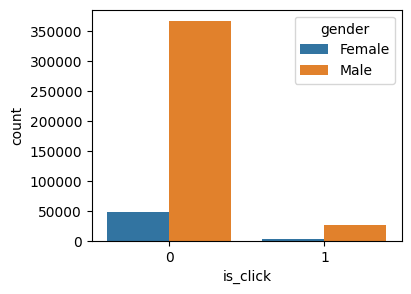

In [6]:
plt.figure(figsize=(4, 3))
sns.countplot(x=df['is_click'],hue=df['gender'])

<Axes: xlabel='is_click', ylabel='count'>

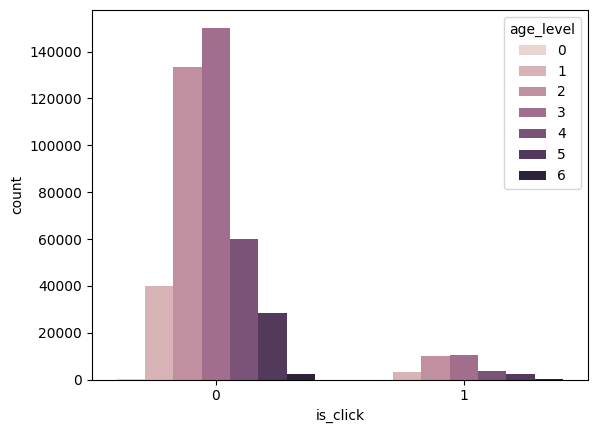

In [7]:
sns.countplot(x=df['is_click'],hue=df['age_level'])

<Axes: >

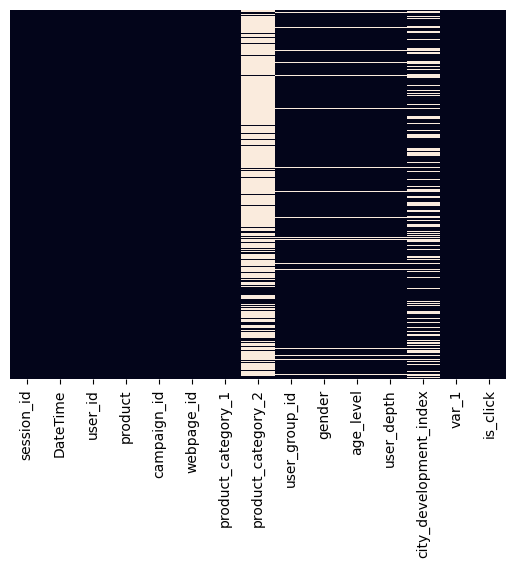

In [ ]:
sns.heatmap(df.isna(),yticklabels=False,cbar=False)

# Избаваляемся от пустых значений

In [12]:
df.drop(labels='product_category_2', axis=1, inplace=True)

In [13]:
sum(df['is_click'] == 1)

31331

In [14]:
# Рандомно заполняем индекс развития городов
num_missing = df['city_development_index'].isnull().sum()
if num_missing > 0:
    missing_indices = df['city_development_index'].isnull()
    num_missing_values = num_missing
    replace_values = np.random.choice([1, 2, 3, 4], size=num_missing_values, p=[0.25, 0.25,0.25,0.25])
    df['city_development_index'][missing_indices] = replace_values

<ipython-input-14-d290278eeb26>:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['city_development_index'][missing_indices] = replace_values
<ipython-input-14-d290278eeb26>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [15]:
df.isna().sum()

,0
session_id,0
DateTime,0
user_id,0
product,0
campaign_id,0
webpage_id,0
product_category_1,0
user_group_id,18243
gender,18243
age_level,18243


In [16]:
df = df.dropna()

In [17]:
df.isna().sum()

,0
session_id,0
DateTime,0
user_id,0
product,0
campaign_id,0
webpage_id,0
product_category_1,0
user_group_id,0
gender,0
age_level,0


In [18]:
sum(df['is_click'] == 1)

30057

<Axes: >

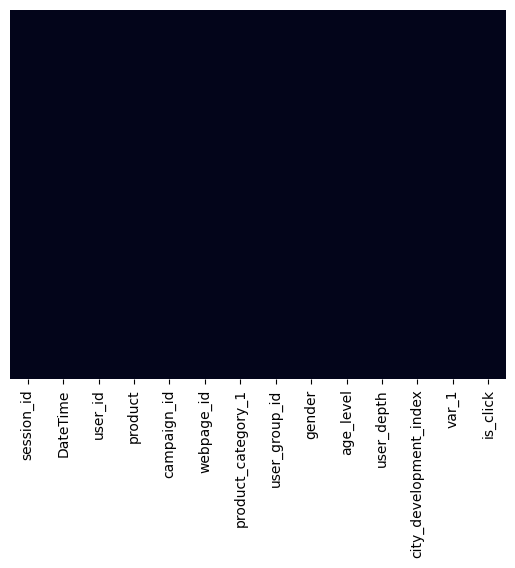

In [19]:
sns.heatmap(df.isna(),yticklabels=False,cbar=False)

In [20]:
df.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,140690,2017-07-02 00:00,858557,C,359520,13787,4,10.0,Female,4.0,3.0,3.0,0,0
1,333291,2017-07-02 00:00,243253,C,105960,11085,5,8.0,Female,2.0,2.0,2.0,0,0
2,129781,2017-07-02 00:00,243253,C,359520,13787,4,8.0,Female,2.0,2.0,1.0,0,0
3,464848,2017-07-02 00:00,1097446,I,359520,13787,3,3.0,Male,3.0,3.0,2.0,1,0
4,90569,2017-07-02 00:01,663656,C,405490,60305,3,2.0,Male,2.0,3.0,2.0,1,0


# Label encoding

In [21]:
LE = LabelEncoder()
df['gender'] = LE.fit_transform(df['gender'])
df['product'] = LE.fit_transform(df['product'])

In [22]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['DateTime'] = df['DateTime'].dt.hour

In [23]:
df.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,140690,0,858557,2,359520,13787,4,10.0,0,4.0,3.0,3.0,0,0
1,333291,0,243253,2,105960,11085,5,8.0,0,2.0,2.0,2.0,0,0
2,129781,0,243253,2,359520,13787,4,8.0,0,2.0,2.0,1.0,0,0
3,464848,0,1097446,8,359520,13787,3,3.0,1,3.0,3.0,2.0,1,0
4,90569,0,663656,2,405490,60305,3,2.0,1,2.0,3.0,2.0,1,0


In [24]:
df['is_click'].value_counts()

,count
is_click,
0,414991
1,30057


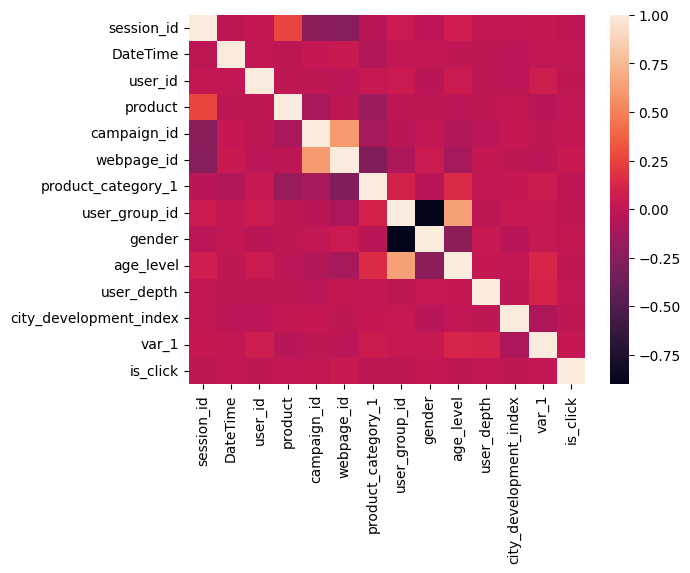

In [25]:
sns.heatmap(df.corr())
plt.show()

<ipython-input-26-39bfb385db5e>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='DateTime',


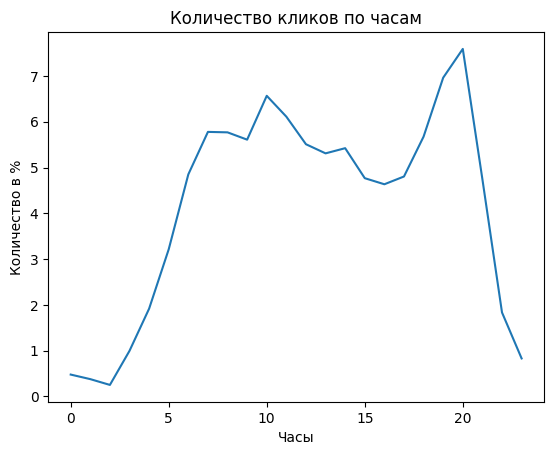

In [26]:
Is_clicked = df[df['is_click']==1]
Is_clicked_hour = Is_clicked.groupby('DateTime').agg('sum').reset_index()
Is_clicked_hour['is_click'] = 100*Is_clicked_hour['is_click']/sum(Is_clicked_hour['is_click'])
Is_clicked_hour

sns.lineplot(x='DateTime',
             y='is_click',
             data=Is_clicked_hour,
             palette='Set2')

plt.title('Количество кликов по часам')
plt.xlabel('Часы')
plt.ylabel('Количество в %')

plt.show()

# Уменьшение дисбаланс классов

In [27]:
# Стратифицированный подход
df_sampled = df.groupby('is_click').apply(lambda x: x.sample(n=7000 if x.name == 1 else 20000)).reset_index(drop=True)

<ipython-input-27-c412fe023bd8>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('is_click').apply(lambda x: x.sample(n=7000 if x.name == 1 else 20000)).reset_index(drop=True)


In [28]:
df_sampled['is_click'].value_counts()
x_1 = df_sampled.drop(['is_click','session_id'],axis=1)
y_1 = df_sampled['is_click']
print('Clicked:',sum(y_1==1))
print('Not clicked:',sum(y_1==0))

Clicked: 7000
Not clicked: 20000


In [29]:
scaler = StandardScaler()
x_1 = scaler.fit_transform(x_1)
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_1, y_1, test_size=0.2, shuffle=True)

In [40]:
x_train_1.shape

(21600, 12)

In [42]:
y_test_1.shape

(5400,)

In [30]:
# Синтетический оверсемплинг
df_2 = df.sample(n=30000)
x_2 = df_2.drop(['is_click','session_id'],axis=1)
y_2 = df_2['is_click']

In [31]:
x_2 = scaler.fit_transform(x_2)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_2, y_2, test_size=0.3, shuffle=True)

In [32]:
sm = SMOTE(random_state=2)
x_train_2, y_train_2 = sm.fit_resample(x_train_2, y_train_2)

In [33]:
pd.Series(y_train_2).value_counts()

,count
is_click,
1,19558
0,19558


In [34]:
pd.Series(y_test_2).value_counts()

,count
is_click,
0,8357
1,643


In [35]:
x_train_2.shape

(39116, 12)

In [36]:
x_test_2.shape

(9000, 12)

# Обучение модели

In [37]:
classifiers = {
    'LogisticRegression':LogisticRegression(),
    "KNN":KNeighborsClassifier(),
    'DT':DecisionTreeClassifier(),
    'RFC':RandomForestClassifier(),
    'Bagging':BaggingClassifier(),
    'SGD':SGDClassifier(),
    'GBC':GradientBoostingClassifier(),
    'xgb':XGBClassifier(),
    #'CatBoost':CatBoostСlassifier()
}

In [38]:
def accuracy_score(X_train, y_train):
    for key, classifier in classifiers.items():
        classifier.fit(X_train, y_train)
        training_score = cross_val_score(classifier, X_train, y_train, cv=5)
        print("Classifier Name : ", classifier.__class__.__name__,"  Training Score ：", round(training_score.mean(), 2)*100,'%')

In [43]:
accuracy_score(x_train_1, y_train_1)

Classifier Name :  LogisticRegression   Training Score ： 74.0 %
Classifier Name :  KNeighborsClassifier   Training Score ： 69.0 %
Classifier Name :  DecisionTreeClassifier   Training Score ： 62.0 %
Classifier Name :  RandomForestClassifier   Training Score ： 71.0 %
Classifier Name :  BaggingClassifier   Training Score ： 70.0 %
Classifier Name :  SGDClassifier   Training Score ： 74.0 %
Classifier Name :  GradientBoostingClassifier   Training Score ： 74.0 %
Classifier Name :  XGBClassifier   Training Score ： 72.0 %


In [ ]:
accuracy_score(x_train_2, y_train_2)

Classifier Name :  LogisticRegression   Training Score ： 53.0 %
Classifier Name :  KNeighborsClassifier   Training Score ： 85.0 %
Classifier Name :  DecisionTreeClassifier   Training Score ： 90.0 %
Classifier Name :  RandomForestClassifier   Training Score ： 95.0 %
Classifier Name :  BaggingClassifier   Training Score ： 94.0 %
Classifier Name :  SGDClassifier   Training Score ： 53.0 %
Classifier Name :  GradientBoostingClassifier   Training Score ： 88.0 %
Classifier Name :  XGBClassifier   Training Score ： 94.0 %


In [ ]:
#train_pool = Pool(x_train_1, x_train_1, cat_features=cat_features)
#test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [ ]:
def LR_gs(X_train, y_train):
    LR_param = {
        'penalty':['l1', 'l2'],
        'C':[0.001, 0.01, 0.1, 1, 10]
    }

    LR_gs = GridSearchCV(LogisticRegression(),param_grid=LR_param, n_jobs=-1, scoring='accuracy')
    LR_gs.fit(X_train, y_train)

    LR_estimators = LR_gs.best_estimator_

    return LR_estimators

def KNN_gs(X_train, y_train):
    KNN_param = {
        'n_neighbors':list(range(2, 5, 1)),
        'algorithm':['auto','ball_tree','kd_tree','brute']
    }

    KNN_gs = GridSearchCV(KNeighborsClassifier(), param_grid=KNN_param, n_jobs=-1, scoring='accuracy')
    KNN_gs.fit(X_train, y_train)

    KNN_estimators = KNN_gs.best_estimator_

    return KNN_estimators
def SVC_gs(X_train, y_train):
    SVC_param = {
        'C':[0.5, 0.7, 0.9, 1],
        'kernel':['rfb', 'sigmod','poly']
    }

    SVC_gs = GridSearchCV(SVC(), param_grid=SVC_param, n_jobs=-1, scoring='accuracy')
    SVC_gs.fit(X_train, y_train)

    SVC_estimators = SVC_gs.best_estimator_

    return SVC_estimators
def DT_gs(X_train, y_train):
    DT_param = {
        'criterion':['gini', 'entropy'],
        'max_depth':list(range(2, 5, 1)),
        'min_samples_leaf':list(range(3, 7, 1))
    }

    DT_gs = GridSearchCV(DecisionTreeClassifier(), param_grid=DT_param, n_jobs=-1, scoring='accuracy')
    DT_gs.fit(X_train, y_train)

    DT_estimators = DT_gs.best_estimator_

    return DT_estimators
def RFC_gs(X_train, y_train):
    RFC_param = {
        'n_estimators':[100, 150, 200],
        'criterion':['gini', 'entropy'],
        'max_depth':list(range(2,5,1)),
    }

    RFC_gs = GridSearchCV(RandomForestClassifier(), param_grid=RFC_param, n_jobs=-1, scoring='accuracy')
    RFC_gs.fit(X_train, y_train)

    RFC_estimators = RFC_gs.best_estimator_

    return RFC_estimators
def BAG_gs(X_train, y_train):
    BAG_param = {
        'n_estimators':[10, 15, 20]
    }

    BAG_gs = GridSearchCV(BaggingClassifier(), param_grid=BAG_param, n_jobs=-1, scoring='accuracy')
    BAG_gs.fit(X_train, y_train)

    BAG_estimators = BAG_gs.best_estimator_

    return BAG_estimators
def SGD_gs(X_train, y_train):
    SGD_param = {
        'penalty':['l2','l1'],
        'max_iter':[1000, 1500, 2000]
    }

    SGD_gs = GridSearchCV(SGDClassifier(), param_grid=SGD_param, n_jobs=-1, scoring='accuracy')
    SGD_gs.fit(X_train, y_train)

    SGD_estimators = SGD_gs.best_estimator_

    return SGD_estimators
def XGB_gs(X_train, y_train):
    XGB_param = {
        'max_depth':[3,4,5,6]
    }

    XGB_gs = GridSearchCV(XGBClassifier(), param_grid=XGB_param, n_jobs=-1, scoring='accuracy')
    XGB_gs.fit(X_train, y_train)

    XGB_estimators = XGB_gs.best_estimator_

    return XGB_estimators
"""
def CatB(X_train, y_train):
    CatB_param = {
        'max_depth':[3,4,5,6]
    }
    CatB_gs = GridSearchCV(CatBoostСlassifier(), param_grid=CatB_param, n_jobs=-1, scoring='accuracy')
    CatB_gs.fit(X_train, y_train)

    CatB_estimators = CatB_gs.best_estimator_
"""

"\ndef CatB(X_train, y_train):\n    CatB_param = {\n        'max_depth':[3,4,5,6]\n    }\n    CatB_gs = GridSearchCV(CatBoostСlassifier(), param_grid=CatB_param, n_jobs=-1, scoring='accuracy')\n    CatB_gs.fit(X_train, y_train)\n    \n    CatB_estimators = CatB_gs.best_estimator_\n"

In [ ]:
LR_best_estimator = LR_gs(x_train_1,y_train_1)

KNN_best_estimator = KNN_gs(x_train_1,y_train_1)

SVC_best_estimator = SVC_gs(x_train_1,y_train_1)

DT_best_estimator = DT_gs(x_train_1,y_train_1)

RFC_best_estimator = RFC_gs(x_train_1,y_train_1)

BAG_best_estimator = BAG_gs(x_train_1,y_train_1)

SGD_best_estimator = SGD_gs(x_train_1,y_train_1)

XGB_best_estimator = XGB_gs(x_train_1,y_train_1)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver

In [ ]:
LR_best_estimator = LR_gs(x_train_2,y_train_2)

KNN_best_estimator = KNN_gs(x_train_2,y_train_2)

SVC_best_estimator = SVC_gs(x_train_2,y_train_2)

DT_best_estimator = DT_gs(x_train_2,y_train_2)

RFC_best_estimator = RFC_gs(x_train_2,y_train_2)

BAG_best_estimator = BAG_gs(x_train_2,y_train_2)

SGD_best_estimator = SGD_gs(x_train_2,y_train_2)

XGB_best_estimator = XGB_gs(x_train_2,y_train_2)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver

In [ ]:
result_df1 = pd.DataFrame(columns=['Accuracy', 'F1-score', 'Recall', 'Precision', 'AUC_ROC'],
                         index=['LR','KNN','DT','RFC','Bagging','SGD','XGB, CatBoost'])
def caculate(models, X_test, y_test):

    accuracy_results = []
    F1_score_results = []
    Recall_results = []
    Precision_results = []
    AUC_ROC_results = []

    for model in models:
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)
        AUC_ROC = roc_auc_score(y_test, y_pred) # AUC


        accuracy_results.append(accuracy)
        F1_score_results.append(f1_score)
        Recall_results.append(recall)
        AUC_ROC_results.append(AUC_ROC)
        Precision_results.append(precision)
    return accuracy_results, F1_score_results, Recall_results, AUC_ROC_results, Precision_results
best_models = [LR_best_estimator, KNN_best_estimator, DT_best_estimator, RFC_best_estimator,
               BAG_best_estimator, SGD_best_estimator, XGB_best_estimator]
accuracy_results, F1_score_results, Recall_results, AUC_ROC_results, Precision_results = caculate(best_models,x_test_1,y_test_1)
result_df1['Accuracy'] = accuracy_results
result_df1['F1-score'] = F1_score_results
result_df1['Recall'] = Recall_results
result_df1['Precision'] = Precision_results
result_df1['AUC_ROC'] = AUC_ROC_results
result_df1

,Accuracy,F1-score,Recall,Precision,AUC_ROC
LR,0.545370,"[0.6478267106584421, 0.3588404283102638]","[0.5640769422932801, 0.4917680744452398]","[0.7607816711590296, 0.2824835526315789]",0.527923
KNN,0.707407,"[0.8207803992740472, 0.20362903225806453]","[0.90382213339995, 0.14459556191839656]","[0.7517141076251818, 0.3441226575809199]",0.524209
DT,0.541852,"[0.6611887154204328, 0.29273870783304745]","[0.6030477142143392, 0.36649964209019326]","[0.7317368899666565, 0.24369347929557353]",0.484774
RFC,0.302407,"[0.1440581685980459, 0.41131426785435227]","[0.07919060704471646, 0.9420186113099499]","[0.7964824120603015, 0.2630947620951619]",0.510605
Bagging,0.292222,"[0.11527777777777778, 0.4101851851851852]","[0.062203347489382964, 0.9513242662848962]","[0.7854889589905363, 0.26145976785362973]",0.506764
SGD,0.573889,"[0.682050573442034, 0.3541959023294976]","[0.6165375968023982, 0.4516821760916249]","[0.7631416202844774, 0.291320406278855]",0.534110
"XGB, CatBoost",0.260741,"[0.007952286282306162, 0.41086186540731995]","[0.003997002248313765, 0.9964209019327129]","[0.7619047619047619, 0.2587841606246514]",0.500209


In [ ]:
best_models = [LR_best_estimator, KNN_best_estimator,  DT_best_estimator, RFC_best_estimator,
               BAG_best_estimator, SGD_best_estimator, XGB_best_estimator]
result_df2 = pd.DataFrame(columns=['Accuracy', 'F1-score', 'Recall', 'Precision', 'AUC_ROC'],
                         index=['LR','KNN','DT','RFC','Bagging','SGD','XGB'])
accuracy_results, F1_score_results, Recall_results, AUC_ROC_results, Precision_results = caculate(best_models,x_test_2,y_test_2)
result_df2['Accuracy'] = accuracy_results
result_df2['F1-score'] = F1_score_results
result_df2['Recall'] = Recall_results
result_df2['Precision'] = Precision_results
result_df2['AUC_ROC'] = AUC_ROC_results
result_df2

,Accuracy,F1-score,Recall,Precision,AUC_ROC
LR,0.556000,"[0.7011666168112474, 0.1365600691443388]","[0.5597611940298507, 0.5056]","[0.9381628977386431, 0.07894079440419685]",0.532681
KNN,0.844444,"[0.914996964177292, 0.08496732026143791]","[0.8997014925373135, 0.104]","[0.9308214947498455, 0.0718232044198895]",0.501851
DT,0.924889,"[0.960938402866058, 0.025936599423631124]","[0.9928358208955224, 0.0144]","[0.9310267607210838, 0.13043478260869565]",0.503618
RFC,0.741889,"[0.8483582479274104, 0.13353226408056695]","[0.7758805970149254, 0.2864]","[0.9357718894009217, 0.08706225680933852]",0.531140
Bagging,0.899444,"[0.9469239340801126, 0.04636459430979979]","[0.9639402985074627, 0.0352]","[0.9304979253112033, 0.06790123456790123]",0.499570
SGD,0.609556,"[0.7473759884974839, 0.14083129584352078]","[0.6206567164179104, 0.4608]","[0.9391147244805781, 0.08311688311688312]",0.540728
XGB,0.925667,"[0.9613674423976439, 0.020497803806734993]","[0.9939104477611941, 0.0112]","[0.9308879445314248, 0.1206896551724138]",0.502555
